In [1]:
import nbimporter
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from kaggle_dataset import read
from pre_processing import get_class_positive, get_lenght_class_positive, adjusts_the_unbalance, normalize_dataframe

Importing Jupyter notebook from kaggle_dataset.ipynb
Importing Jupyter notebook from pre_processing.ipynb


In [2]:
# INFO: READ DATASET
# -- leitura dos dados originais

In [3]:
dataframe_credit_card_fraud = read("dataset/creditcard.csv")

In [4]:
# INFO: TRAINING MODEL (KNN AND LEAVE_ONE_OUT)
# -- visto que ficaram poucos registro (haviam poucos da classe positiva)
# -- assim foi utilizado o metodo leave-one-out para validar os modelos
# -- garantindo que cada registro aparece pelo menos uma vez no treino e teste

In [5]:
def training_with_leave_one_out(execution, k_range, data, target):
    scores_accuracy = {}
    scores_f1_score = {}
    confusion_matrix_values = {}  
    for k in k_range:
        loo = LeaveOneOut()
        targets_test = []
        targets_predict = [] 
        target_test_index = 0

        for train_index, test_index in loo.split(data):
            data_train, data_test = data.loc[train_index], data.loc[test_index]
            target_train, target_test = target.loc[train_index], target.loc[test_index]
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(data_train, target_train)
            target_predict = knn.predict(data_test)
            
            targets_test.append(target_test[target_test_index])
            targets_predict.append(target_predict[0])
            
            target_test_index += 1
        
        scores_accuracy[k] = metrics.accuracy_score(targets_test, targets_predict)
        scores_f1_score[k] = metrics.f1_score(targets_test, targets_predict)
        
        if not os.path.exists("result/predicts/"):
            os.makedirs("result/predicts/")
        
        pd.DataFrame(targets_test, targets_predict).to_csv("result/predicts/predicts_ex_" + str(execution) + "_k_" + str(k) + "_.csv", sep=',', encoding='utf-8')
        
        confusion_matrix_values[k] = targets_test, targets_predict
    
    if not os.path.exists("result/metrics/"):
        os.makedirs("result/metrics/")
        
    pd.DataFrame(list(scores_accuracy.items())).to_csv("result/metrics/accuracy_ex_" + str(execution) + "_.csv", sep=',', encoding='utf-8')
    pd.DataFrame(list(scores_f1_score.items())).to_csv("result/metrics/f1_score_ex_" + str(execution) + "_.csv", sep=',', encoding='utf-8')

    return scores_accuracy, scores_f1_score, confusion_matrix_values

In [6]:
# -- definindo o range do parametro k do algoritmo knn
# -- preparando o dataset balanceado e normalizado
# -- executando o range de k 10 vezes pegando variações aleatorias ao fazer o balanceamento dos dados
# -- fazendo a media das metricas de avaliação (acurácia e f1-score) nas 10 execuções

In [7]:
k_range = range(1, 50, 2)

scores_accuracy = {}
scores_f1_score = {}

execution_number = 10

for execution in range(execution_number):
    dataframe_class_positive = get_class_positive(dataframe_credit_card_fraud)
    lenght_class_positive = get_lenght_class_positive(dataframe_class_positive)
    
    dataframe_balanced = adjusts_the_unbalance(lenght_class_positive, dataframe_class_positive, dataframe_credit_card_fraud)
    dataframe_normalize = normalize_dataframe(dataframe_balanced)
    
    if not os.path.exists("dataset/"):
            os.makedirs("dataset/")
    
    dataframe_normalize.to_csv("dataset/creditcard_balanced_normalize_" + str(execution) + ".csv", sep=',', encoding='utf-8')
    dataframe_normalize = read("dataset/creditcard_balanced_normalize_" + str(execution) + ".csv")
    
    data = dataframe_normalize.iloc[:, 2:29]
    target = dataframe_normalize["Class"]

    accuracy, f1_score, confusion_matrix_values = training_with_leave_one_out(execution, k_range, data, target)
    
    for k in k_range:
        if (k in scores_accuracy):
            scores_accuracy[k] = float(scores_accuracy[k]) + float(accuracy[k])
            scores_f1_score[k] = float(scores_f1_score[k]) + float(f1_score[k])
        else:
            scores_accuracy[k] = float(accuracy[k])
            scores_f1_score[k] = float(f1_score[k])
    
for k in k_range:
    scores_accuracy[k] = scores_accuracy[k]/execution_number
    scores_f1_score[k] = scores_f1_score[k]/execution_number

In [8]:
# INFO: SCORE GRAPHIC
# -- funçào para plotar o score de cada parâmetro k do algoritmo

In [9]:
def score_graphic(x, y, y_label):
    plt.plot(x, y)
    plt.xlabel("Value of k for KNN")
    plt.ylabel(y_label)
    plt.grid()

In [10]:
# INFO: SCORE GRAPHIC (ACCURACY)

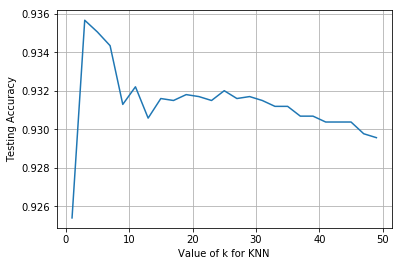

In [11]:
score_graphic(k_range, scores_accuracy.values(), "Testing Accuracy")

In [12]:
# INFO: CONFUSION MATRIX
# -- necessário para analisar os dados desbalanceados
# -- extrair as metricas de avaliação

In [13]:
def plot_confusion_matrix(values_true, values_predict):
    cm = metrics.confusion_matrix(values_true, values_predict)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["False", "True"])
    plt.yticks(tick_marks, ["False", "True"])
    plt.ylabel('Value true')
    plt.xlabel('Value predict')

In [14]:
# INFO: CONFUSION MATRIX (BEST RESULT)
# -- função para plotar a matriz de confusão que teve melhor média de score

In [15]:
def best_confusion_matrix(scores, confusion_matrix_values):
    INDEX_VALUES_TRUE = 0
    INDEX_VALUES_PREDICT = 1
    
    key_max_score = max(scores, key=scores.get)
    
    values_true = confusion_matrix_values[key_max_score][INDEX_VALUES_TRUE]
    values_predict = confusion_matrix_values[key_max_score][INDEX_VALUES_PREDICT]
    
    plot_confusion_matrix(values_true, values_predict)
    print("------------------------------------")
    print(metrics.confusion_matrix(values_true, values_predict))
    print("------------------------------------")
    tn, fp, fn, tp = metrics.confusion_matrix(values_true, values_predict).ravel()
    
    print("TN: " + str(tn))
    print("FP: " + str(fp))
    print("FN: " + str(fn))
    print("TP: " + str(tp))
    print("------------------------------------")

In [16]:
# INFO: CONFUSION MATRIX (BEST RESULT - ACCURACY)

------------------------------------
[[476  16]
 [ 55 437]]
------------------------------------
TN: 476
FP: 16
FN: 55
TP: 437
------------------------------------


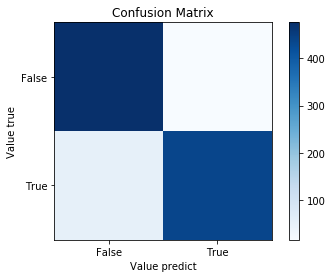

In [17]:
best_confusion_matrix(scores_accuracy, confusion_matrix_values)

In [18]:
# INFO: SCORE GRAPHIC (F1-SCORE)

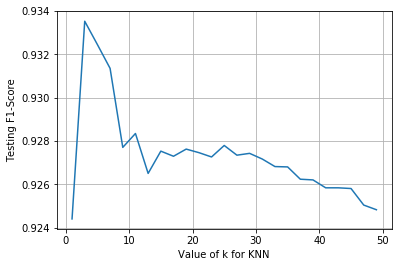

In [19]:
score_graphic(k_range, scores_f1_score.values(), "Testing F1-Score")

In [20]:
# INFO: CONFUSION MATRIX (BEST RESULT - F1-SCORE)

------------------------------------
[[476  16]
 [ 55 437]]
------------------------------------
TN: 476
FP: 16
FN: 55
TP: 437
------------------------------------


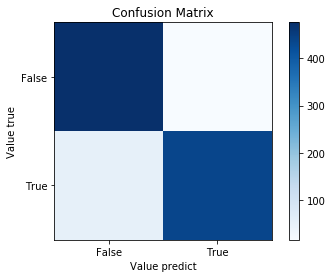

In [21]:
best_confusion_matrix(scores_f1_score, confusion_matrix_values)